In [13]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Constantes
PATH_TO_ROOT = "../../"
PATH_DATA = PATH_TO_ROOT + "data/"
PATH_RAW = PATH_DATA + "raw/"
PATH_PROCESSED = PATH_DATA + "processed/"
PATH_EXTERNAL = PATH_DATA + "external/"
SEED = 123

pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)


# Chargement des données

In [5]:
df = pd.read_csv(PATH_PROCESSED + "X_train_preprocessed.csv", index_col=0)
# df = pd.read_csv(PATH_PROCESSED + "X_train_detected_language.csv", index_col=0)
# df_target = pd.read_csv(PATH_RAW + "y_train.csv", index_col=0)
# df[df_target.columns[0]] = df_target
display(df.head())
display(df.describe())
display(df.info())

stop_words_french = pd.read_json(PATH_EXTERNAL + "stop_words_french.json")
print(stop_words_french.shape)
stop_words = []
stop_words.extend(stop_words_french[0].tolist())
stop_words.extend(["cm", "mm"])
print(len(stop_words))
stop_words[:10]

,productid,imageid,text,lemmes,len_text,len_lemmes,prdtypecode
0,3804725264,1263597046,pages de carnet personnalisées olivia dot grid...,page de carnet personnalisé olivia dot grid ca...,68,64,10
1,436067568,1008141237,journal des arts le n du l art et son marche s...,journal des art le ne du l art et son marche s...,177,172,2280
2,201115110,938777978,grand stylet ergonomique bleu gamepad nintendo...,grand stylet ergonomique bleu gamepad nintendo...,731,732,50
3,50418756,457047496,peluche donald europe disneyland marionnette à...,peluche donald europe disneyland marionnette à...,52,52,1280
4,278535884,1077757786,la guerre des tuques luc a des idées de grande...,la guerre des tuques luc a des idée de grandeu...,203,212,2705


,productid,imageid,len_text,len_lemmes,prdtypecode
count,8.491600e+04,8.491600e+04,84916.000000,84916.000000,84916.000000
mean,2.555468e+09,1.152691e+09,520.531537,517.319422,1773.219900
std,1.588656e+09,1.751427e+08,664.802838,660.806625,788.179885
min,1.839120e+05,6.728400e+04,4.000000,4.000000,10.000000
25%,6.760519e+08,1.056269e+09,57.000000,56.000000,1281.000000
50%,3.190506e+09,1.213354e+09,265.000000,263.000000,1920.000000
75%,3.995599e+09,1.275646e+09,806.000000,803.000000,2522.000000
max,4.252012e+09,1.328824e+09,11919.000000,12066.000000,2905.000000


<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productid    84916 non-null  int64 
 1   imageid      84916 non-null  int64 
 2   text         84916 non-null  object
 3   lemmes       84916 non-null  object
 4   len_text     84916 non-null  int64 
 5   len_lemmes   84916 non-null  int64 
 6   prdtypecode  84916 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 5.2+ MB


None

(496, 1)
498


['a', 'à', 'â', 'abord', 'afin', 'ah', 'ai', 'aie', 'ainsi', 'allaient']

In [6]:
value_counts = df["prdtypecode"].value_counts()
median = int(value_counts.quantile(0.5))
print("median :", median)
value_counts_index = value_counts[value_counts > median].index
print(value_counts_index)

median : 2671
Index([2583, 1560, 1300, 2060, 2522, 1280, 2403, 2280, 1920, 1160, 1320, 10,
       2705],
      dtype='int64', name='prdtypecode')


In [7]:
to_split = True

index_row = []
if to_split:
    for i in value_counts.index:
        if i in value_counts_index:
            index_row.extend(
                df.loc[df["prdtypecode"] == i].sample(n=median, random_state=SEED).index
            )
        else:
            index_row.extend(df.loc[df["prdtypecode"] == i].index)
else:
    index_row.extend(df.index)

data = df.loc[df.index.isin(index_row)]["text"]
target = df.loc[df.index.isin(index_row)]["prdtypecode"].astype("str")
print(data.shape)
print(target.shape)

(57552,)
(57552,)


In [8]:
le = LabelEncoder()

target = le.fit_transform(target)

# TfidfVectorizer

Voici les paramètres qui me semblent importants pour une classification de texte sur un corpus de 90 000 textes d'environ 500 caractères chacun:

- Le paramètre <b>ngram_range</b>, qui permet de générer des n-grams de caractères ou de mots. Pour un texte court, les unigrams et bigrams seraient probablement suffisants. 

- Le paramètre <b>max_features</b>, qui limite le nombre de features conservées. Étant donné le grand nombre de textes, il serait sage de limiter le nombre de features pour éviter le surapprentissage. 

- Le paramètre <b>min_df</b>, qui ignore les mots apparaissant dans trop peu de documents. Ici, on peut ignorer les mots n'apparaissant que dans quelques dizaines de textes sur 90 000.

- Le paramètre <b>max_df</b>, qui ignore les mots trop fréquents comme les mots vides. Avec des textes courts, de nombreux mots apparaitront dans une grande proportion des textes.

- Le paramètre <b>stop_words</b>, pour retirer les mots vides de la langue du corpus.

- Le paramètre <b>lowercase</b>, pour mettre tous les mots en minuscules et ainsi neutraliser les variations casse.

Voilà les principaux paramètres à prendre en compte pour cette tâche de classification de texte sur un grand corpus de textes courts.

In [9]:
tfidf_vect = TfidfVectorizer(
    sublinear_tf=True,
    max_df=0.5,
    min_df=0.00001,
    lowercase=True,
    stop_words=stop_words,
    max_features=350000,
)

data_vec = tfidf_vect.fit_transform(data)

# Split data into training and testing sets
X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    data_vec, target, test_size=0.2, random_state=SEED
)

print("X_train shape :", X_train_vec.shape)
print("X_test shape  :", X_test_vec.shape)

/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['quelqu'] not in stop_words.
  warnings.warn(


X_train shape : (46041, 111531)
X_test shape  : (11511, 111531)


# SMOTE

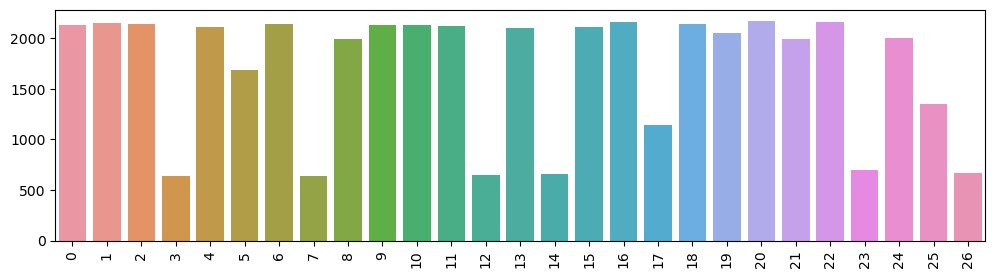

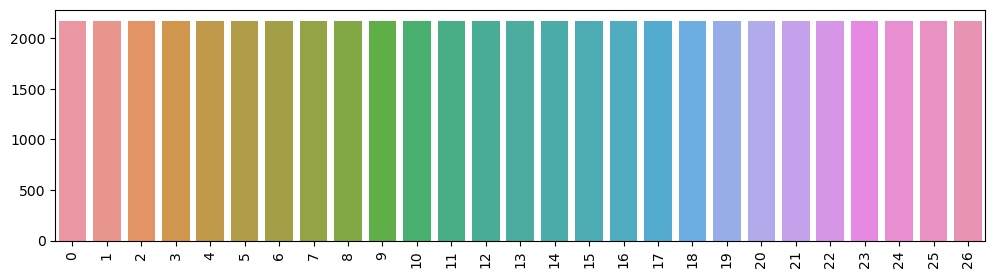

X_train shape : (58698, 111531)
X_test shape  : (11511, 111531)


In [10]:
# count = y_train.value_counts().to_frame()
unique_values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 3))
sns.barplot(x=unique_values, y=counts)
plt.xticks(rotation=90)
plt.show()

smote = SMOTE(random_state=SEED)
X_train_vec, y_train = smote.fit_resample(X_train_vec, y_train)

unique_values, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(12, 3))
sns.barplot(x=unique_values, y=counts)
plt.xticks(rotation=90)
plt.show()
print("X_train shape :", X_train_vec.shape)
print("X_test shape  :", X_test_vec.shape)

if X_train_vec.shape[0] * X_train_vec.shape[1] < 100000000:
    X_train_dense = X_train_vec.toarray()
    unique_rows, counts = np.unique(X_train_dense, axis=0, return_counts=True)
    duplicate_rows = unique_rows[counts > 1]

    if len(duplicate_rows) > 0:
        print(f"Found {len(duplicate_rows)} duplicate rows in the matrix.")
    else:
        print("No duplicate rows found in the matrix.")

## XGBoost

In [21]:
import mlflow

mlflow.set_tracking_uri(PATH_TO_ROOT + "mlruns")  # "http://127.0.0.1:8080"
mlflow.set_experiment(experiment_name="XGBClassifier_model")
# log_datasets=False car les dimensions du dataset sont trop importantes pour les enregistrer
mlflow.autolog(log_datasets=False)

Traceback (most recent call last):
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/fil

Traceback (most recent call last):
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1320, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/mlflow/store/tracking/fil

In [22]:
# Define parameters to search over
params = {
    "n_estimators": [30, 50],
    "max_depth": [3, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Create the XGBClassifier
xgb = XGBClassifier(objective="multi:softmax", random_state=SEED)

# Create a GridSearchCV object with the desired estimator and parameter grid
grid_search = GridSearchCV(
    xgb, params, cv=3, verbose=2, scoring="f1_weighted", n_jobs=4
)

# Fit the model to the data
grid_search.fit(X_train_vec, y_train)

best_params = grid_search.best_params_

print(best_params)
print(grid_search.best_score_)

2024/04/09 16:54:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c0d58f4495a44324bbaacc1884ff2bad', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.6;, score=0.658 total time=  27.4s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.6;, score=0.659 total time=  27.9s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.6;, score=0.646 total time=  29.0s
[CV 1/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.8;, score=0.648 total time=  29.9s
[CV 3/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.8;, score=0.658 total time=  29.9s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=0.8;, score=0.662 total time=  30.6s
[CV 2/3] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=30, subsample=1.0;, score=0.656 total time=  31.6s
[CV 1/3] END 

2024/04/09 20:07:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/jeremyrava/anaconda3/envs/bds_rakuten_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/04/09 20:07:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, 157 runs will be omitted.


{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'subsample': 1.0}
0.7857420687832248


In [23]:
clf = XGBClassifier(
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    n_estimators=best_params["n_estimators"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
)

clf.fit(X_train_vec, y_train)

print("Score train :", clf.score(X_train_vec, y_train))
print("Score test :", clf.score(X_test_vec, y_test))

y_pred = clf.predict(X_test_vec)

f1_train = metrics.f1_score(y_train, clf.predict(X_train_vec), average="weighted")
f1_test = metrics.f1_score(y_test, y_pred, average="weighted")

print("F1 score train :", f1_train.round(3))
print("F1 score test :", f1_test.round(3))

2024/04/09 20:25:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '12ee7a4e3b4c4c8199d767eb76b19e1f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


Score train : 0.8591263756857133
Score test : 0.7375553818087047
F1 score train : 0.87
F1 score test : 0.75
